# Abstract

Mask R-CNN은 instance segmentation문제를 해결하기 위한 모델로써, R-CNN 계열의 모델에 속한다. 이에 대한 개념적 지식을 바탕으로 Kaggle의 'Training Mask R-CNN to be a Fashionista'를 review하도록 한다. 먼저 설명하자면 이 커널은 dataset의 전처리가 대부분이고 실제 모델을 가져와 사용하는 부분은 일부분에 불과하다. 어떻게보면 모델은 이미 만들어져있기때문에 실제 문제에 적용시키기 위해서는 모델에 맞게 데이터를 정제하는 작업이 중요한 것이 사실이다. 따라서 이번 code review는 모델의 주요한 개념을 다루기보다는 모델을 사용하기 위해 문제로 주어진 dataset을 어떻게 전처리하는지를 파악하는 것을 목표로 한다.

# GPU check

이번 Kaggle code review가 나에겐 첫 Kaggle Kernel 시도이다. GPU를 설정하고 아래의 코드를 통해 GPU 사용여부를 확인할 수 있다. 참고로 Kaggle은 1주일에 30시간의 GPU 자원을 제공한다.

In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13374257406636572362
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1138928220755162752
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17737025553266613296
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15884438733
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16653588774138726030
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [2]:
from keras import backend as K

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

# Dataset Introduction

Welcome to the world where fashion meets computer vision! This is a starter kernel that applies Mask R-CNN with COCO pretrained weights to the task of [iMaterialist (Fashion) 2019 at FGVC6](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6).

<img src="https://s3.amazonaws.com/ifashionist/Kaggle/dataset_example.jpg" width="100%">

In [3]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [4]:
print(os.listdir('/kaggle/input/'))

['imaterialist-fashion-2019-FGVC6']


In [5]:
DATA_DIR = Path('/kaggle/input/imaterialist-fashion-2019-FGVC6')
ROOT_DIR = Path('/kaggle/working')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks

# imaterialist-fashion-2019-FGVC6
# To capture the complex structure of fashion objects and ambiguity in descriptions obtained from crawling the web,
# our standardized taxonomy contains 46 apparel objects (27 main apparel items and 19 apparel parts),
# and 92 related fine-grained attributes.

NUM_CATS = 46
IMAGE_SIZE = 512

# Dowload Libraries and Pretrained Weights

COCO dataset으로 pre-trained된 Mask R-CNN 모델을 transfer-learning하기 위해 Github에서 모델을 불러온다.

In [6]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.75 MiB | 48.08 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [7]:
sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [8]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


# Set Config

Mask R-CNN has a load of hyperparameters. I only adjust some of them.

일반적으로 Model의 구성 및 설정은 Config 파일에서 확인하고 변경할 수 있다. 적용하고자 하는 데이터에 따라 설정된 값들을 변경한다.

In [9]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

# Make Datasets

분류할 카테고리 리스트를 만들기 위해 아래와 같은 방법을 사용한다. label_names에 어떤 카테고리명이 있는지 확인하기 위해 리스트의 갯수와 리스트 자체를 출력하여 정보를 볼 수 있다.

In [10]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [11]:
# Check

print('label_names')
print(label_names)
print()
print('Total label_names:',len(label_names))

label_names
['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

Total label_names: 46


In [12]:
segment_df = pd.read_csv(DATA_DIR/"train.csv")

multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

Segments that have attributes: 3.47%


Segments that contain attributes are only 3.46% of data, and [according to the host](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/90643#523135), 80% of images have no attribute. So, in the first step, we can only deal with categories to reduce the complexity of the task.

위의 코드를 보면 segment_df의 ClassId중에 \_가 포함된 row의 비율을 확인한다. 그 이유는 ClassId의 구성을 살펴보면 알 수 있다.

In [13]:
# check: What is attributes?

segment_df[segment_df['ClassId'].str.contains('_')].head()

,ImageId,EncodedPixels,Height,Width,ClassId
42,000aac3870ea7c59ca0333ffa5327323.jpg,8971124 17 8975101 49 8979077 82 8983053 116 8...,4000,6000,10_3_20_34_56_69_91
44,000aac3870ea7c59ca0333ffa5327323.jpg,8621972 2 8625970 5 8629968 9 8633966 13 86379...,4000,6000,3_1_10_20_41_60_61_91
48,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,291578 3 292856 8 294133 13 295410 19 296687 2...,1280,852,10_5_19_33_59_61_66_88
92,000e973c99dc090afd7898c93daf0dbc.jpg,4796962 5 4801882 14 4806801 24 4811721 33 481...,4928,3264,4_0_20_41_60_72_88
97,000e973c99dc090afd7898c93daf0dbc.jpg,5798129 11 5803042 35 5807956 58 5812870 80 58...,4928,3264,6_8_20_39_60_70


segment_df의 ClassId column을 살펴보면 우리가 분류하려는 46가지 카테고리의 번호가 아닌 여러 번호의 조합으로 이루어져있다. 그 이유는 datset의 구성에서 확인할 수 있다. 해당 dataset은 46가지 대분류 이외에도 92가지의 atrributes를 가지고 있다. 이에 대한 정확한 정보는 확인하지 못했으나, 이번 분류의 목표는 46가지 대분류이기 때문에 그 이외의 정보들은 지워야 한다. ClassId의 가장 첫 번째 값이 46가지 대분류에 속하기 때문에 이 값만을 취하기로 한다. 방법은 아래와 같다.

In [14]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  331213


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


46가지 카테고리가 잘 되어있는지 확인하기 위해 segment['CategoryId']의 max값을 구해 45를 출력하는지 검증한다.

In [15]:
print(max(segment_df['CategoryId'].astype('int')))    # CategoryID: 0~45

45


Rows with the same image are grouped together because the subsequent operations perform in an image level.<br><br>
후속 작업이 이미지 수준에서 수행되기 때문에 동일한 이미지를 가진 행이 함께 그룹화된다.<br>
특히 EncodedPixels와 CategoryId는 segment 각각에 대한 정보이므로 list를 만들어 모두 저장을 하고, Height와 width는 Image별로 같은 정보이므로 단순히 mean()값을 사용한다.<br>
그 결과 총 331213개의 segment들을 Image단위로 그룹화하여 45195개의 Image의 정보가 들어있는 dataframe을 생성했다.

In [16]:
# Total segments:  331213
# Total images:  45195
# One Image has some segments which have each EncodedPixels, CategoryID

image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  45195


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


# What is EncodedPixels?

segments의 column중에 EncodedPixels가 있다. 아래의 출력결과를 보면 굉장히 많은 숫자들이 리스트형식으로 저장되어 있음을 확인할 수 있다. 과연 이 값은 무엇을 의미할까?

In [17]:
# check: What is EncodedPixels?

print('length of EncodedPixels:', len(image_df['EncodedPixels'][0][0]))
print(image_df['EncodedPixels'][0][0])

length of EncodedPixels: 21303
6068157 7 6073371 20 6078584 34 6083797 48 6089010 62 6094223 72 6099436 76 6104649 80 6109862 85 6115075 89 6120288 93 6125501 98 6130714 102 6135927 106 6141140 111 6146354 114 6151567 118 6156780 123 6161993 127 6167206 131 6172419 136 6177632 140 6182845 144 6188058 149 6193271 153 6198484 157 6203697 162 6208910 166 6214124 169 6219337 174 6224550 178 6229763 182 6234976 187 6240189 191 6245402 195 6250615 200 6255828 204 6261041 208 6266254 213 6271467 218 6276680 224 6281893 229 6287107 233 6292320 238 6297533 244 6302746 249 6307959 254 6313172 259 6318385 265 6323598 270 6328811 275 6334024 280 6339237 286 6344450 291 6349663 296 6354877 300 6360090 306 6365303 311 6370516 316 6375729 322 6380942 327 6386155 332 6391368 337 6396581 343 6401794 348 6407007 353 6412220 358 6417433 364 6422647 368 6427860 373 6433073 378 6438286 384 6443499 389 6448712 394 6453925 399 6459138 405 6464351 410 6469564 415 6474777 420 6479990 426 6485203 431 6490416 43

kernel을 공부할 때 아래와 같은 설명을 달았는데, 간단히 설명하자면 다음과 같다.<br>
EncodedPixels는 (시작점, 점의 개수) 쌍으로 이루어진 숫자들의 집합이다. Instance Segmentation 문제는 Object Detection과 동시에 Segmentation을 수행해야하므로 물체가 있는 곳을 1로, 물체가 없는 곳을 0으로 masking한 정보가 필요하다. 이를 간단히 표현한 방법이라고 할 수 있겠다.<br>
간단한 예를 들어 설명하겠다. 10 by 10 Image에서 물체가 있는 곳을 1로 표현할 수 있는 방법을 생각해보자. 단순하게 생각하면 같은 10 by 10 numpy를 만들어서 물체가 있는 곳을 1, 없는 곳을 0의 값을 부여하면 될 것이다. 하지만 이는 sparse matrix가 될 가능성이 높으므로 매우 비효율적인 방법이다. 따라서 보편적으로 이용하는 방법은 (시작점, 점의 개수) 쌍을 이용하는 방법이다. 만약 masking해야하는 부분이 (3,3), (3,4), (3,5), (3,6)이라고 해보자. 이는 (3,3)부터 시작해서 4개의 점에 해당한다. 이를 표현하는 방법은 10 by 10 Image를 펼쳐 (3,3)에 해당하는 16부터 시작해서(0번 index를 잊지 말자) 4개의 점이므로, [16, 4]가 될 것이다. 보통 물체는 한 줄로 이루어지는 형상은 아니므로 이러한 값들이 많을 것이다. (3,3), (3,4), (3,5), (3,6), (4,3), (4,4), (4,5), (4,6)이면 직사각형 부분을 masking했다고 생각할 수 있다. 이를 EncodedPixels로 표현하면, [16, 4, 25, 4] 가 된다. 즉, 16번째 점부터 4개의 점, 25번째 점부터 4개의 점을 의미한다. 이러한 방식으로 EncodexPixels의 정보를 표현한다.

I was able to learn what it is with a site.<br>
The address of the site is as follows.<br>
https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0

Here is the custom function that resizes an image.

In [18]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)    # (512, 512)
    return img

위 코드는 특정 이미지를 입력할 모델에 맞게 resize를 해 주는 함수로써, 기존에 설정한 (512,512)의 shape으로 바꿔준다.

The crucial part is to create a dataset for this task.

Kernel의 저자는 dataset을 업무에 맞도록 바꾸는 작업이 가장 중요하다고 말하고 있다. 모델을 해결하고자 하는 문제에 적용하기 위해서 가장 중요하게 봐야할 부분이라고 생각한다. 특히 주석 처리한 Add classes와 Add image를 유심히 봐야 한다. utils.Dataset을 상속받고 있기 때문에 코드를 완벽하게 이해하기 위해서는 상속받은 클래스 또한 이해해야 할 것이다. 따라서 상속받은 클래스의 코드를 아래에 첨부해놓았다. 간단히 설명하자면, class는 기존에 추가하지 않은 데이터만 추가하는 방식이고 image는 겹치는 데이터가 없기 때문에 바로바로 추가하는 방식이다.

In [19]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)    # self.add_class: from 1 to 46 label number
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]    # image_id == df.iterrows()'s i
        return info['path'], [label_names[int(x)] for x in info['labels']]    # image's path, image's label_names
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        # the information of the one image
        info = self.image_info[image_id]
        
        # len(info['annotation']): the number of a image's segment
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            
            # to use segment's EncodedPixels column
            annotation = [int(x) for x in annotation.split(' ')]
            
            # EncodedPixels consist of a starting point and the number of points.
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask          # mask.shape = (IMAGE_SIZE, IMAGE_SIZE, len(info['annotations']))
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

In [20]:
# utils.py

# class Dataset(object):
#     """The base class for dataset classes.
#     To use it, create a new class that adds functions specific to the dataset
#     you want to use. For example:
#     class CatsAndDogsDataset(Dataset):
#         def load_cats_and_dogs(self):
#             ...
#         def load_mask(self, image_id):
#             ...
#         def image_reference(self, image_id):
#             ...
#     See COCODataset and ShapesDataset as examples.
#     """

#     def __init__(self, class_map=None):
#         self._image_ids = []
#         self.image_info = []
#         # Background is always the first class
#         self.class_info = [{"source": "", "id": 0, "name": "BG"}]
#         self.source_class_ids = {}

#     def add_class(self, source, class_id, class_name):
#         assert "." not in source, "Source name cannot contain a dot"
#         # Does the class exist already?
#         for info in self.class_info:
#             if info['source'] == source and info["id"] == class_id:
#                 # source.class_id combination already available, skip
#                 return
#         # Add the class
#         self.class_info.append({
#             "source": source,
#             "id": class_id,
#             "name": class_name,
#         })

#     def add_image(self, source, image_id, path, **kwargs):
#         image_info = {
#             "id": image_id,
#             "source": source,
#             "path": path,
#         }
#         image_info.update(kwargs)
#         self.image_info.append(image_info)

Let's visualize some random images and their masks.

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/9131dfedb825b064ff784f600a74a642.jpg', ['hat', 'neckline', 'top, t-shirt, sweatshirt', 'shorts'])


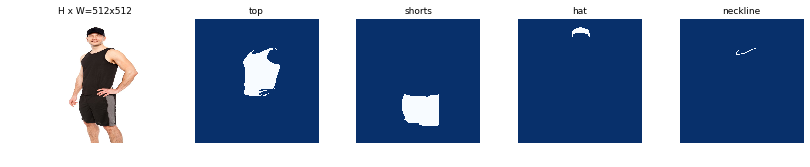

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/06b64521ecfa68e8bb2f3bda263ef8f9.jpg', ['pocket', 'pocket', 'pocket', 'pants'])


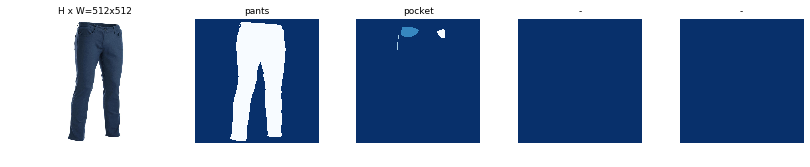

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/13f418e1db5c03169b1fd7045b0cf0e5.jpg', ['dress', 'ruffle', 'neckline', 'shoe', 'shoe'])


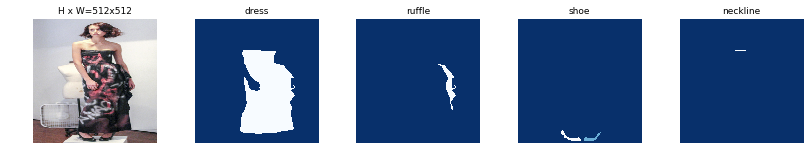

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/1127d6d9a4ad34e3f6ea6abfed23fadf.jpg', ['tie', 'collar', 'shirt, blouse', 'lapel', 'pocket', 'pocket', 'sleeve', 'sleeve', 'jacket', 'pants', 'shoe', 'shoe'])


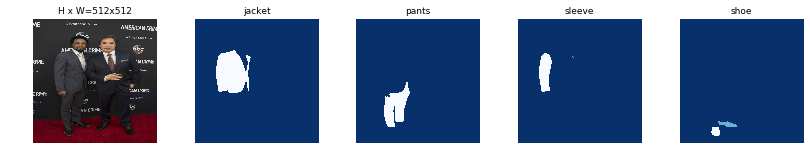

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/bba92b8aad5b628ae4a6c7c9b00e9c0a.jpg', ['neckline', 'dress', 'shoe', 'shoe'])


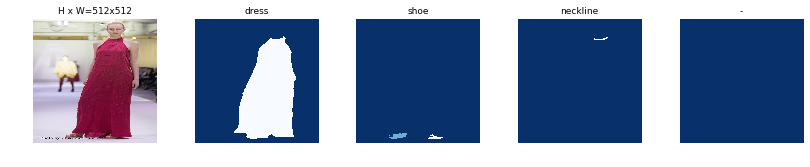

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/04e35028e7ed509bfa145d86f4358174.jpg', ['pocket', 'sleeve', 'pants', 'zipper', 'zipper', 'shoe', 'shoe', 'scarf', 'neckline', 'sleeve', 'sweater'])


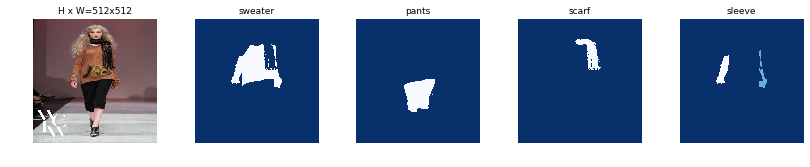

In [21]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

FashionDataset 클래스를 만들어두면 우리가 적용하고자 하는 dataset을 input으로 넣어줌으로써 데이터 전처리 과정이 끝난다. 위의 output을 통해 그 결과를 확인할 수 있다. 한 가지 궁금한점은 shoe나 sleeve처럼 한 쌍으로 이루어진 데이터는 서로 다른 색으로 masking 되어 있다. masking 값을 어떻게 그리고 왜 다르게 주는 것인지가 궁금하다.

Now, the data are partitioned into train and validation sets.

In [22]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here

# What is KFold's split method?
# https://datascienceschool.net/view-notebook/266d699d748847b3a3aa7b9805b846ae/

FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Let's visualize class distributions of the train and validation data.

Total train images:  36156
Total train segments:  264949


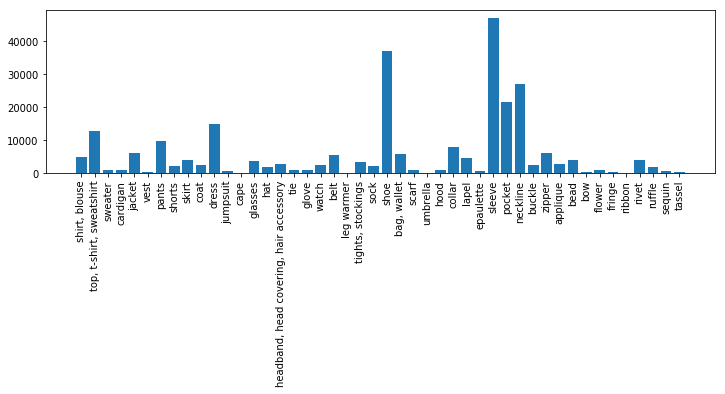

Total validation images:  9039
Total validation segments:  66264


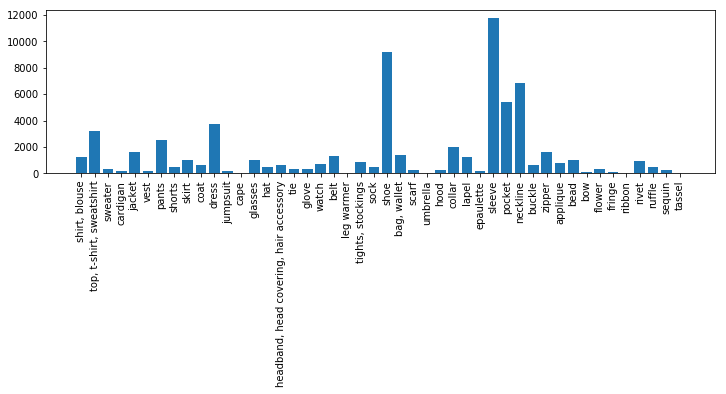

In [23]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total validation images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

모델에 적용하기 위해 KFold method를 이용했는데, train dataset과 validation dataset의 카테고리 비율이 적절하게 분배되었는지 위의 코드를 통해 확인할 수 있다.

# Train

In [24]:
# Note that any hyperparameters here, such as LR, may still not be optimal
LR = 1e-4
EPOCHS = [2, 6, 8]

import warnings 
warnings.filterwarnings("ignore")

This section creates a Mask R-CNN model and specifies augmentations to be used.

In [25]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

First, we train only the heads.

In [27]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history

# learing_rate: 0.0002
# epochs: 2


Starting at epoch 0. LR=0.0002

Checkpoint Path: /kaggle/working/fashion20200430T1111/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4    

# What is heads of model?

해당 Kernel은 heads를 먼저 train하고 전체 layers를 train하는 방식을 택했는데, heads가 어디에 해당하는지가 의문이 들었다. 명확한 답은 얻지 못했지만, 최대한 찾은 바로써는 matterport의 github의 설명에 따르면 아래와 같은 방법으로 모델을 train하라는 가이드가 제시되어있다. train heads branches로 보아서 RPN 이후의 Classification, Regression, Masking 부분을 가리키고 있다고 추측한다.

Train fewer layers. If you're starting from pre-trained COCO or Imagenet weights then the early layers are already trained to extract low-level features and you can benefit from that. Especially if your images are also natural images like the ones in COCO and Imagenet.<br><br>
https://github.com/matterport/Mask_RCNN/wiki

In [28]:
# model.train(..., layers='heads', ...)  # Train heads branches (least memory)
# model.train(..., layers='3+', ...)     # Train resnet stage 3 and up
# model.train(..., layers='4+', ...)     # Train resnet stage 4 and up
# model.train(..., layers='all', ...)    # Train all layers (most memory)

# Loss Function

So, you have 5 "small" losses:<br><br>
rpn_class_loss : How well the Region Proposal Network separates background with objetcs<br>
rpn_bbox_loss : How well the RPN localize objects<br>
mrcnn_bbox_loss : How well the Mask RCNN localize objects<br>
mrcnn_class_loss : How well the Mask RCNN recognize each class of object<br>
mrcnn_mask_loss : How well the Mask RCNN segment objects<br>
That makes a bigger loss:<br><br>
loss : A combination (surely an addition) of all the smaller losses.<br>
All of those losses are calculated on the training dataset.<br><br>
The losses for the validation dataset are those starting with 'val'

<img src="https://i.imgur.com/VS1QuA4.png" width="100%">

Then, all layers are trained.

In [29]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]
    
# learing_rate: 0.0001
# epochs: 6


Starting at epoch 2. LR=0.0001

Checkpoint Path: /kaggle/working/fashion20200430T1111/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b     

Afterwards, we reduce LR and train again.

In [30]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/5,
            epochs=EPOCHS[2],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]
    
# learing_rate: 0.00002
# epochs: 8


Starting at epoch 6. LR=2e-05

Checkpoint Path: /kaggle/working/fashion20200430T1111/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

Let's visualize training history and choose the best epoch.

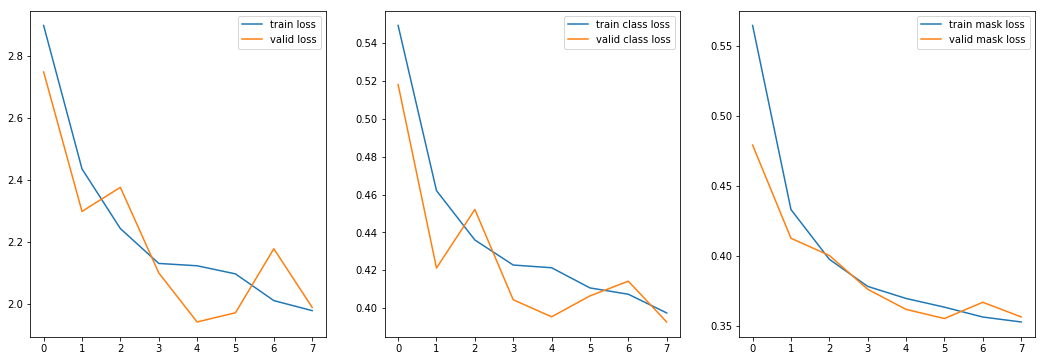

In [31]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [32]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  5
Valid loss:  1.941198120713234


3번의 다른 파라미터 설정으로 학습시킨 모델의 training curve는 위의 그림과 같다. val_loss를 기준으로 5번쨰 epoch에서의 학습이 가장 잘 되었다고 판단했다. 하지만 전체적인 추세로 봤을 때 아직 학습을 통해 모델의 성능이 좋아질 여지가 있다는 것을 확인할 수 있다.

# Predict

The final step is to use our model to predict test data.

In [33]:
glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

This cell defines InferenceConfig and loads the best trained model.

In [34]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /kaggle/working/fashion20200430T1111/mask_rcnn_fashion_0005.h5
Re-starting from epoch 5


Then, load the submission data.

In [35]:
sample_df = pd.read_csv(DATA_DIR/"sample_submission.csv")
sample_df.head()

,ImageId,EncodedPixels,ClassId
0,003d41dd20f271d27219fe7ee6de727d.jpg,1 1,23
1,0046f98599f05fd7233973e430d6d04d.jpg,1 1,23
2,004e9e21cd1aca568a8ffc77a54638ce.jpg,1 1,23
3,005b37fce3c0f641d327d95dd832f51b.jpg,1 1,23
4,0094940c58c343b742f48ae26eb5e9fa.jpg,1 1,23


Here is the main prediction steps, along with some helper functions.

In [36]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [37]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [38]:
%%time
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    image = resize_image(str(DATA_DIR/'test'/row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

  8%|▊         | 245/3200 [03:23<21:30,  2.29it/s]  

error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


The submission file is created, when all predictions are ready.

In [39]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
submission_df.head()

Total image results:  245
Missing Images:  3


,ImageId,EncodedPixels,ClassId
0,003d41dd20f271d27219fe7ee6de727d.jpg,171691 52 172203 53 172715 54 173226 58 173738...,31
1,003d41dd20f271d27219fe7ee6de727d.jpg,72559 9 73065 18 73568 28 74044 2 74058 51 745...,31
2,003d41dd20f271d27219fe7ee6de727d.jpg,170446 9 170955 14 171462 20 171966 30 172475 ...,23
3,003d41dd20f271d27219fe7ee6de727d.jpg,111275 1 111787 1 112813 1 113324 2 113837 1 1...,33
4,003d41dd20f271d27219fe7ee6de727d.jpg,5186 5 5683 74 6194 127 6705 153 7216 167 7728...,31


In [40]:
submission_df.to_csv("submission.csv", index=False)

Finally, it's pleasing to visualize the results! Sample images contain both fashion models and predictions from the Mask R-CNN model.

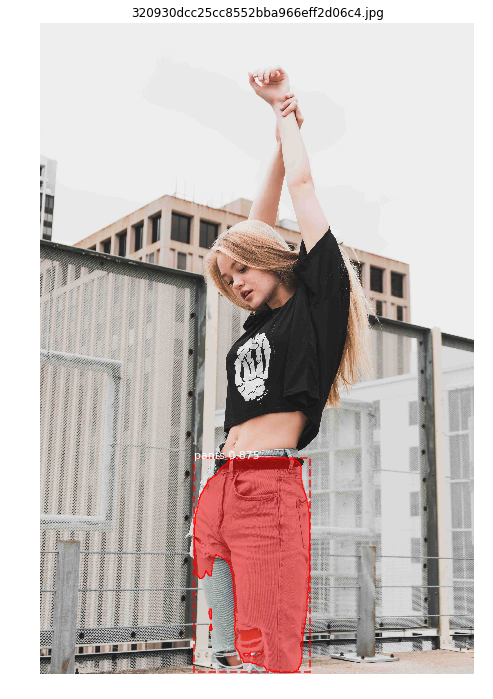

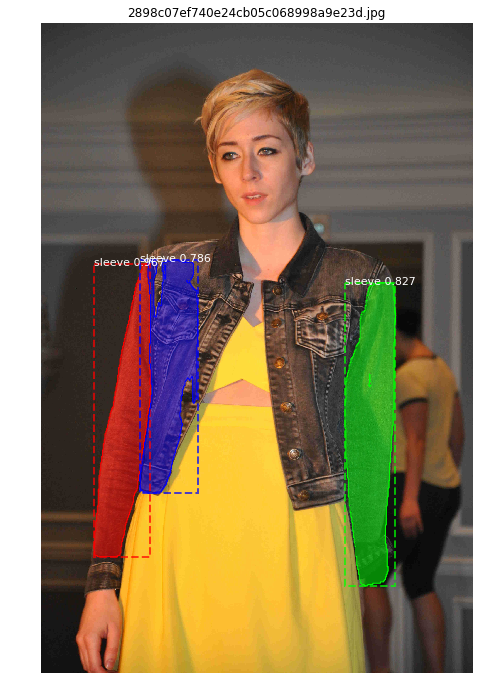

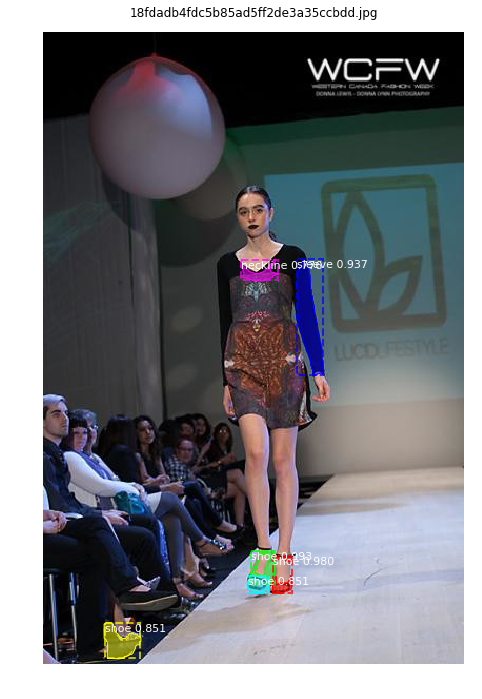

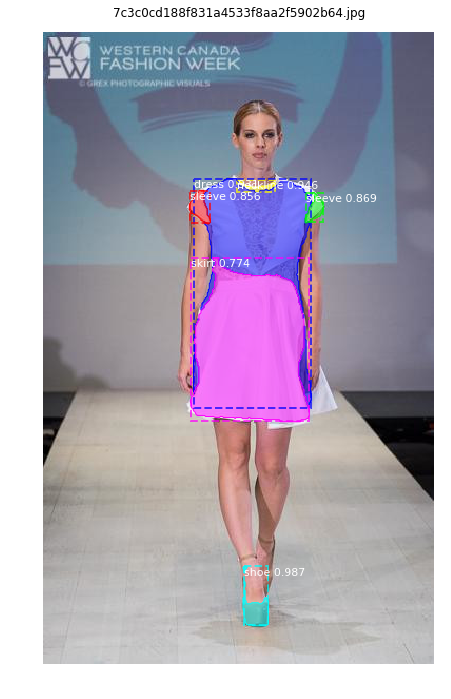

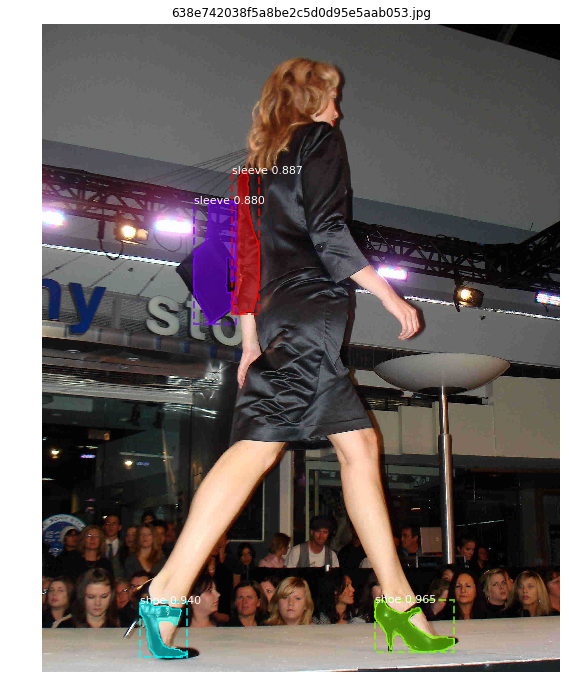

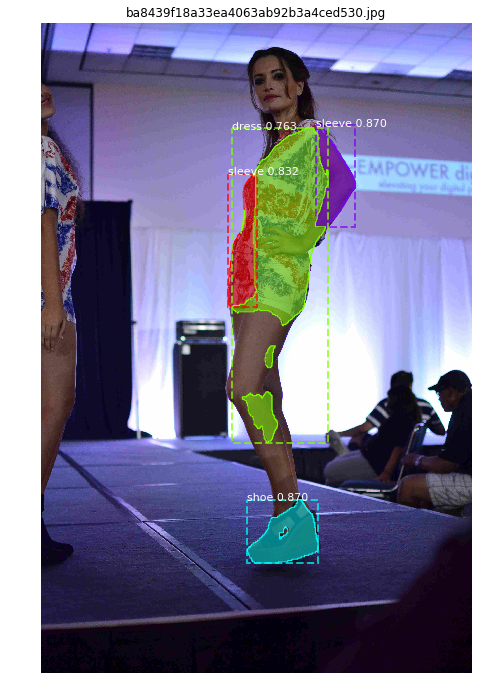

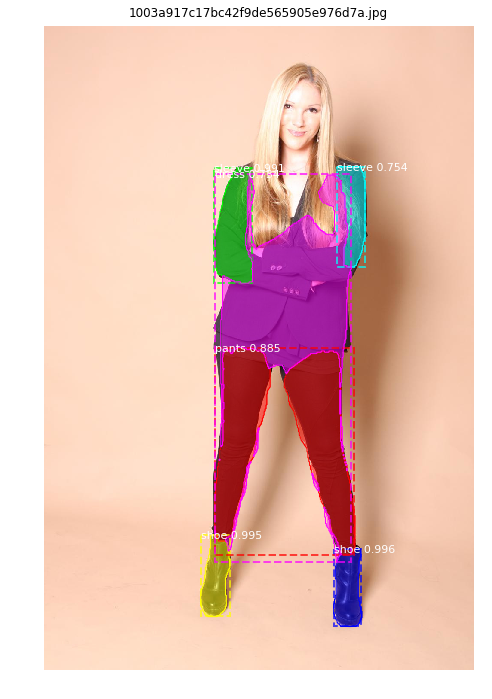

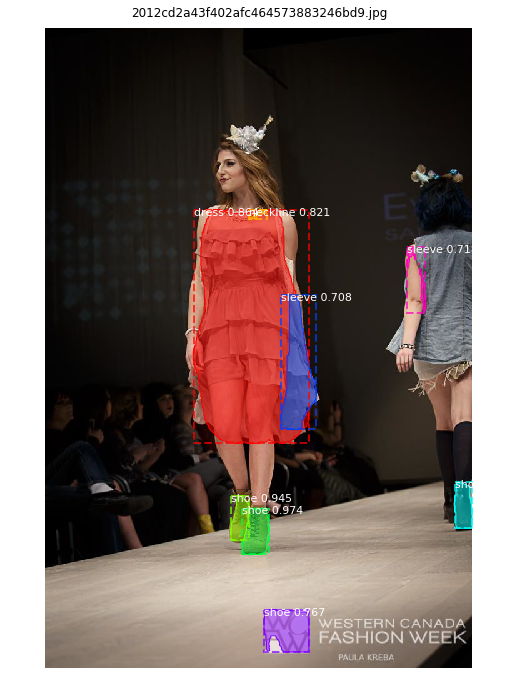

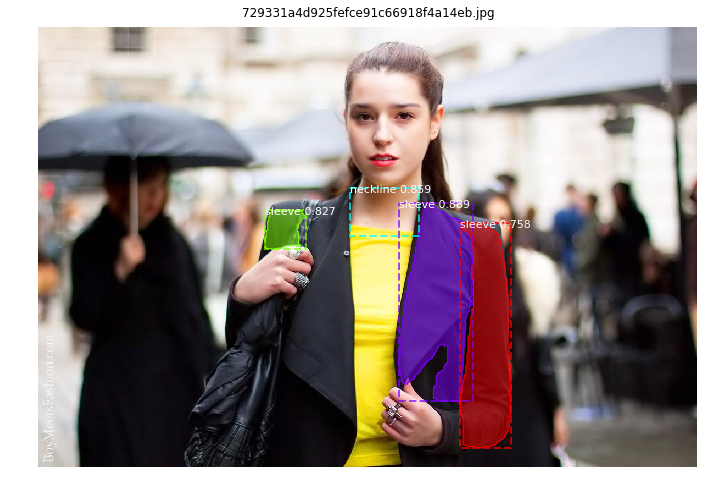

In [41]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(DATA_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

My code is largely based on [this Mask-RCNN kernel](https://www.kaggle.com/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155) and borrowed some ideas from [the U-Net Baseline kernel](https://www.kaggle.com/go1dfish/u-net-baseline-by-pytorch-in-fgvc6-resize). So, I would like to thank the kernel authors for sharing insights and programming techniques. Importantly, an image segmentation task can be accomplished with short code and good accuracy thanks to [Matterport's implementation](https://github.com/matterport/Mask_RCNN) and a deep learning line of researches culminating in [Mask R-CNN](https://arxiv.org/abs/1703.06870).

I am sorry that I published this kernel quite late, beyond the halfway of a timeline. I just started working for this competition about a week ago, and to my surprise, the score fell in the range of silver medals at that time. I have no dedicated GPU and no time to further tune the model, so I decided to make this kernel public as a starter guide for anyone who is interested to join this delightful competition.

<img src='https://i.imgur.com/j6LPLQc.png'>

Hope you guys like this kernel. If there are any bugs, please let me know.

P.S. When clicking 'Submit to Competition' button, I always run into 404 erros, so I have to save a submission file and upload it to the submission page for submitting. The public LB score of this kernel is around **0.07**.

# Reference

Training Mask R-CNN to be a Fashionista (LB≈0.07)
* https://www.kaggle.com/pednoi/training-mask-r-cnn-to-be-a-fashionista-lb-0-07

What meaning all the indicators after training?
* https://github.com/matterport/Mask_RCNN/issues/1112